<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/protected_exceedance_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TLDR:** final analysis pipeline with **protected exceedance probability (PXP)** for model comparison between SR, DK and CK(with transition matrix).

In this copy of the notebook, I am using **neural similarity** (instead of dissimilarity) and I use a **Fisher transform** on the neural similarity matrix. The goal is to figure out why so many subjects cluster at the bottom near 0. Peter Dayan said there is probably something wrong with the model fitting.

# Introduction

This notebook uses the Julich atlas (threshold at prob>0.75) to segment data from Garvert et al. 2017 eLife.
We define hippocampal ROIs including Dentate Gyrus and Cornu Ammonis (no subiculum for now), and segment them according to y=-21 (as in Poppenk et al. 2013 eLife).
The main thing to change is in the section "Load beta map" (i.e. folder and path specification).

# Setup

In [ ]:
threshold = 50 # Threshold for the probabilistic atlas (there is a tradeoff between reliability and number of voxels
normalizeSR = True # Whether to use a row-normalized SR or not
ub = 100 # Bound for the model coefficients
metric = 'correlation' # Metric to use to measure neural similarity!!

## Install and import packages

In [ ]:
!pip install nilearn

In [ ]:
from nilearn import image
from nilearn import plotting, image, datasets
from nilearn.datasets import load_mni152_template
from nilearn.datasets import fetch_atlas_aal
import nibabel as nib
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import tempfile
import os
from PIL import Image
from copy import copy
from nilearn.image import resample_to_img
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from scipy.special import expit
from scipy.special import logit
from nilearn import plotting, image, datasets, masking
from scipy.stats import ttest_rel
from scipy.linalg import expm
from matplotlib.colors import to_rgba
from scipy.stats import t

## Functions

### Segmentation
Functions to segment the hippocampus along the x (left and right) and y (posterior and anterior) axes.

In [ ]:
def segmentHippocampusX(mask, x_index):
  # This function segments the mask along the x axis, into left and right.
  # Note: mask is a 3D boolean array.
  # In the MNI, the midline corresponds to x=0. However, we need to convert it
  # into voxel coordinates.
  # The output is a dictionary with two keys (left and right).

  right = mask.copy() # I use copy to avoid getting views of variables
  left = mask.copy()

  right[:x_index,:,:] = 0
  # then y_index is set to 0 (and discarded)
  end = mask.shape[0]
  left[x_index:end,:,:] = 0

  return {'left': left,
          'right': right}


In [ ]:
def segmentHippocampusY(mask, y_index_anterior, y_index_posterior):
    """
    Segment a hippocampal mask into anterior and posterior portions
    with an optional gap between y_index_posterior and y_index_anterior.

    Parameters
    ----------
    mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    y_index_anterior : int
        #Voxel index corresponding to the *start* of the anterior portion (e.g., y = -18).
    y_index_posterior : int
        #Voxel index corresponding to the *end* of the posterior portion (e.g., y = -24).

    Returns
    -------
    dict
        {'anterior': anterior_mask, 'posterior': posterior_mask}
    """
    anterior_mask = mask.copy()
    posterior_mask = mask.copy()

    end = mask.shape[1]

    # posterior: keep y < y_index_posterior
    posterior_mask[:, y_index_posterior:end, :] = 0

    # anterior: keep y > y_index_anterior
    anterior_mask[:, :y_index_anterior, :] = 0

    return {'posterior': posterior_mask,
            'anterior': anterior_mask}

### Loading data

In [ ]:
def load_beta_images(run_dir, condition_ids):
    betas = []
    for cond_id in condition_ids:
        pattern = f"_object_{cond_id}_mean_beta.nii.gz" #alternative: _mean_beta_np.nii.gz (or f"_object_{cond_id}_mean_beta.nii.gz" or f"_concat_object_{cond_id}_beta.nii.gz")
        files = [f for f in os.listdir(run_dir) if pattern in f]
        assert len(files) == 1, f"Expected one match for {pattern}"
        img = nib.load(os.path.join(run_dir, files[0]))
        betas.append(img.get_fdata().flatten())  # flatten to 1D voxel vector
    return np.vstack(betas)  # shape (7, n_voxels)

In [ ]:
def extractBetas(beta_img, mask_img):
  # This function take a .nii image from beta_img and from mask_imgs
  # it put them in the same reference frame and then use the latter as a boolean
  # mask
  # The function returns a vector with n elements, where n is the number of non-
  # zero elemnts in mask_img

  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)

  beta_data = beta_img.get_fdata()
  mask_data = resampled_mask_img.get_fdata()

  mask_bool = mask_data > 0  # Ensure mask is binary

  masked_betas = beta_data[mask_bool]
  return masked_betas

### Others

In [ ]:
def fisher_z_clip(r, eps=1e-6):
    """
    Apply Fisher z-transform safely by clipping correlations
    to avoid ±1 -> ±inf issues.
    """
    r = np.clip(r, -1 + eps, 1 - eps)  # clip to [-0.999999, +0.999999]
    z = np.arctanh(r)
    return z

In [ ]:
def computeSR(T, gamma, normalize=False):
  # This function computes the SR matrix from a transition matrix T
  # and a gamma value.
  # If normalize=True, SR will be row-normalized, making it alike probabilities
  I = np.eye(T.shape[0])
  difference = I - gamma * T
  # Compute the inverse of (I - gamma * T)
  M = np.linalg.inv(difference)
  if normalize:
    M = M / M.sum(axis=1, keepdims=True)
  return M

In [ ]:
def offdiagonal(M):
  offmask = ~np.eye(M.shape[0], dtype=bool)
  return M[offmask]

In [ ]:
def communicabilityK(T, alpha, normalize=False):
  K = expm(alpha * T)
  if normalize:
    K = K / offdiagonal(K).sum(axis=1, keepdism=True)
  return K

In [ ]:
def computeDK(A, alpha):
  degrees = np.sum(A, axis=1)
  D = np.diag(degrees)
  L = D - A
  K = expm(-alpha * L)
  return K

In [ ]:
def corr_triangles(M1, M2):
  # To correlate neural similarity and model similarity, we need to
  # discard the diagonal. We can't just use squareform because SR is not
  # symmetric necessarily
  M1 = M1[~np.eye(M1.shape[0], dtype=bool)]
  M2 = M2[~np.eye(M2.shape[0], dtype=bool)]
  return pearsonr(M1, M2)

In [ ]:
def zscore_matrix(M):
    """Z-score off-diagonal elements of a symmetric matrix."""
    mask = ~np.eye(M.shape[0], dtype=bool)
    vals = M[mask]
    M_z = (M - vals.mean()) / vals.std(ddof=1)
    return M_z

In [ ]:
from scipy.stats import ttest_rel, t as t_dist

# Define ROIs
In this section the main things to decide are:


*   Probability threshold: Julich atlas is probablistic, so to get binary masks (where a voxel is assigned to 1 only if it belongs to the ROI) we need to threshold it. The value is chosen in line with previous studies (Barnavelli et al. 2025 Nat Commun) and it also corresponds to a sort of elbow in voxel reliability (there is a tradeoff between # of selected voxels and reliability)
*   ROI definition. For now, we define the hippocampus as DG + CA



## Load Juelich brain atlas

In [ ]:
julich = datasets.fetch_atlas_juelich("prob-1mm")
julich_img = image.load_img(julich.maps)
julich_data = julich_img.get_fdata()
julich_labels = julich.labels

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

In [ ]:
CA_idx = julich_labels.index("GM Hippocampus cornu ammonis") - 1
DG_idx = julich_labels.index("GM Hippocampus dentate gyrus") - 1
#S_idx = julich_labels.index("GM Hippocampus subiculum") - 1

In [ ]:
CA = (julich_data[..., CA_idx] > threshold)
DG = (julich_data[..., DG_idx] > threshold)
#S = (julich_data[..., S_idx] > threshold)

# This now returns a 3D boolean array
HP = CA | DG

/tmp/ipython-input-2003817921.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')
/tmp/ipython-input-2003817921.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')


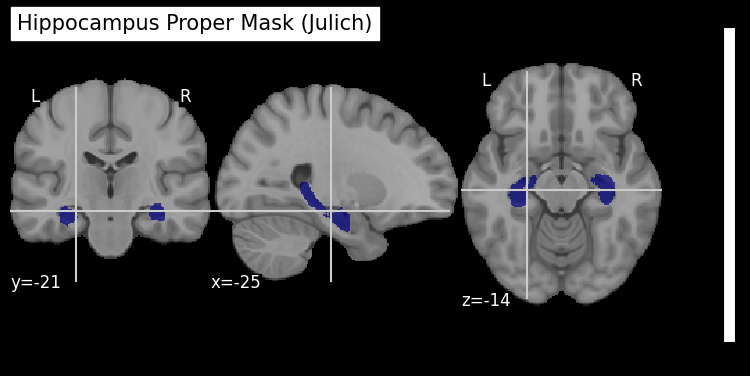

In [ ]:
mni_img = datasets.load_mni152_template(resolution=1)

# Step 2: Convert your HP mask to a NIfTI image
hp_mask_img = nib.Nifti1Image(HP.astype(np.uint8), affine=julich_img.affine)

# Step 3: Resample the mask to match the MNI template (if needed)
hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')

# Step 4: Plot the mask over the MNI template
plotting.plot_roi(hp_mask_resampled, bg_img=mni_img, title="Hippocampus Proper Mask (Julich)", cut_coords=[-25,-21, -14])
plotting.show()

## Segment into left and right

In [ ]:
mni_x = 0
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
x_index, _, _ = np.round(inv_affine @ np.array([mni_x, 0, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
sagittal_segmentation = segmentHippocampusX(HP, x_index)

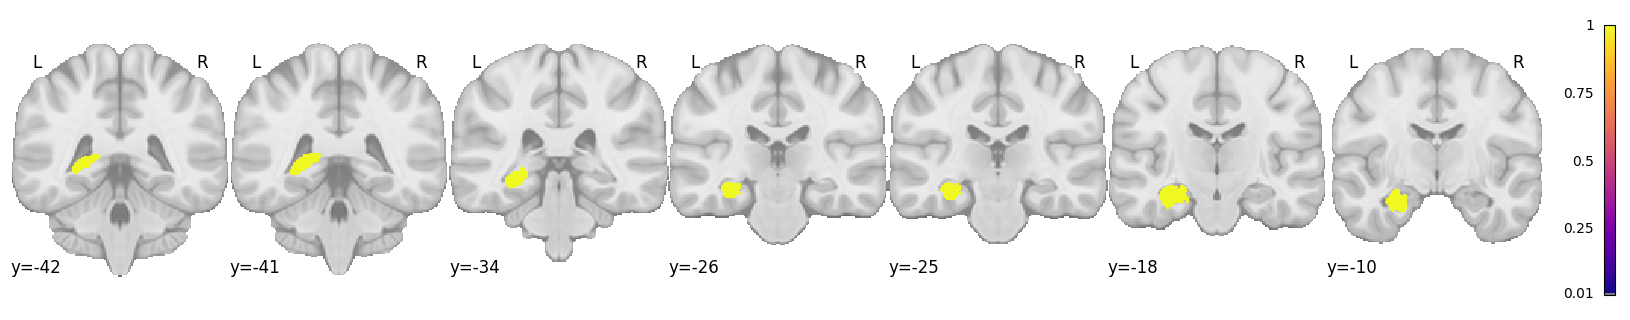

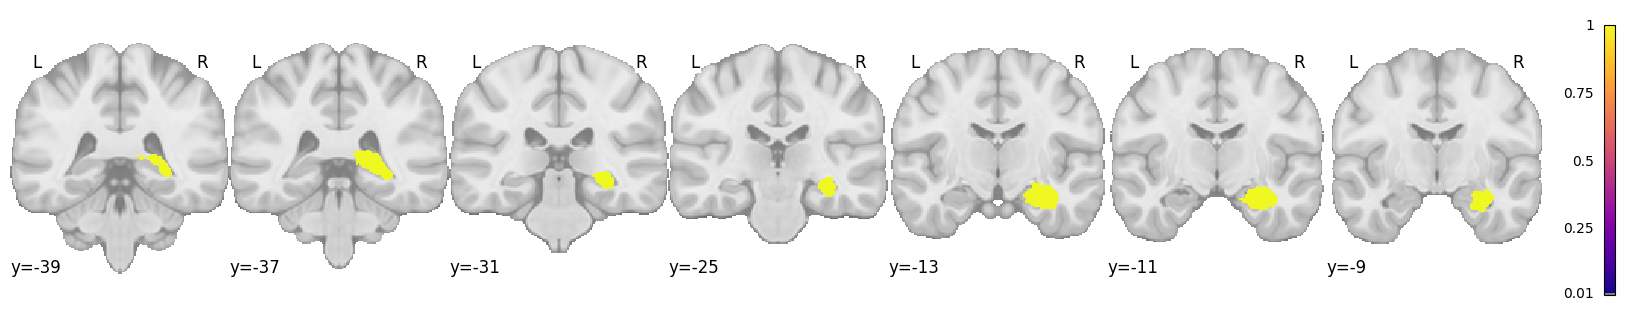

In [ ]:
for h in sagittal_segmentation:
  plotting.plot_stat_map(
      nib.Nifti1Image(sagittal_segmentation[h].astype(np.uint8), affine),
      bg_img=mni_img,
      display_mode="y",
      draw_cross=False,
      threshold=0.01,
      black_bg=False,
      colorbar=True,
      cmap="plasma",
      vmin=0,
      vmax=1
  )
plotting.show()

## Segment into anterior and posterior

Because the data were smoothed with a 8mm FWHM Gaussian kernel, this means that for each voxel, within an 8mm span, there could be spatial autocorrelation! This is really important when specifying the boundaries for the anterior and posterior ROI parts. We want to take the y-coordinate of -21 to specify the anterior and posterior ROI boundaries (Brunec et al., 2018; Poppenk et al., 2013). Since the MNI coordinates are in mm, we decided to subtract 4 from -21, so -17 for the anterior boundary and -25 for the posterior boundary. Even though our "gap" is not a-priori justified, this is still a feasible and careful approach! :)

In [ ]:
# Convert y = -14 and y = -28 MNI coordinates to voxel indices #those were the coordinates where I got statistically significant results for the two-tailed paired t-test before
mni_y = [-15, -27]  # new anterior/posterior boundaries
affine = julich_img.affine
inv_affine = np.linalg.inv(affine)  # transform MNI coordinates into matrix indices

# Compute voxel indices for both y values
_, y_index_anterior, _ = np.round(inv_affine @ np.array([0, mni_y[0], 0, 1])).astype(int)[:3]
_, y_index_posterior, _ = np.round(inv_affine @ np.array([0, mni_y[1], 0, 1])).astype(int)[:3]

# Fill masks: segment each hemisphere mask into anterior/posterior parts
masks = {
    h: segmentHippocampusY(seg, y_index_anterior, y_index_posterior)
    for h, seg in sagittal_segmentation.items()
}

# Convert each resulting ROI to a NIfTI image
masks_img = {
    h: {
        roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        for roi, arr in rois.items()
    }
    for h, rois in masks.items()
}

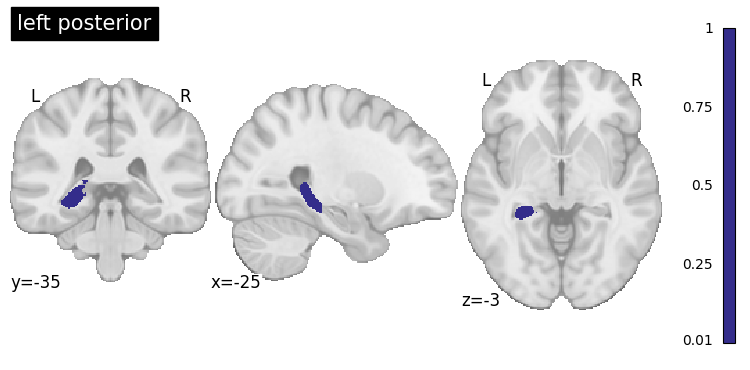

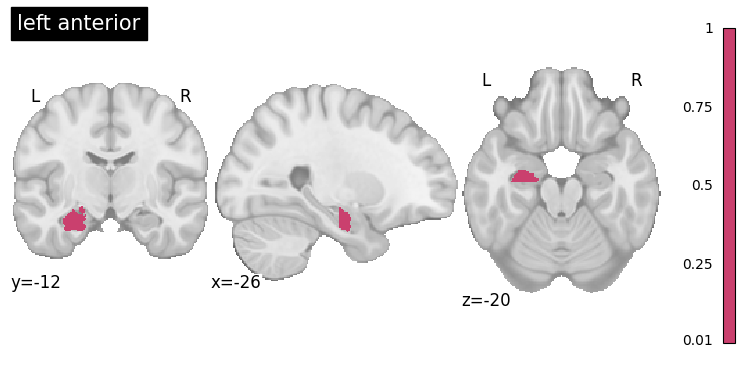

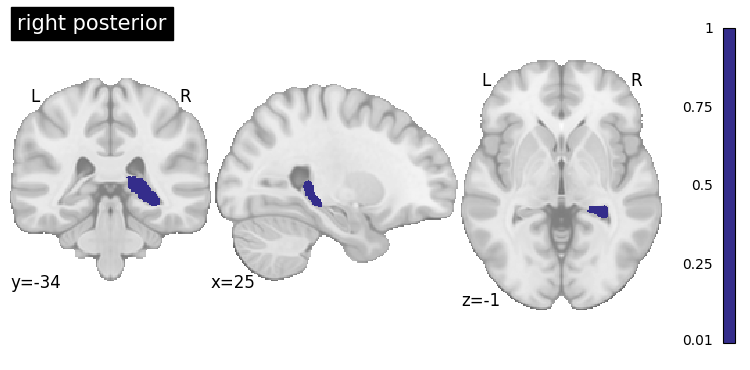

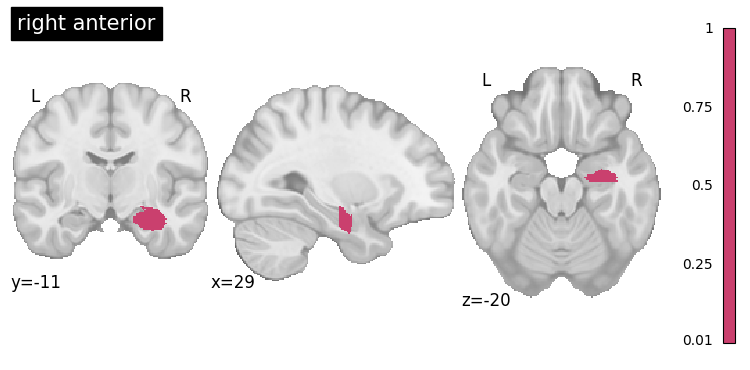

In [ ]:
# Check: visualize the longitudinal axis segmentation
colors = {"posterior": '#342d8bff',
          "anterior": '#ca406eff'}
for h in masks_img:
  for roi in masks_img[h]:
    plotting.plot_stat_map(
        masks_img[h][roi],
        bg_img=mni_img,
        draw_cross=False,
        threshold=0.01,
        black_bg=False,
        colorbar=True,
        cmap=mcolors.ListedColormap([[0, 0, 0, 0], colors[roi]]),
        vmin=0,
        vmax=1,
        title=h + " " + roi
    )
  plotting.show()

# Load beta maps

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# A-L's new version

import os
import numpy as np
import nibabel as nib

# Parameters
items = [2, 4, 6, 7, 8, 9, 10]
nItems = len(items)
nParticipants = 23
participants = np.arange(1, nParticipants + 1)

main_folder = "/content/drive/MyDrive/betas_allpatch/" #change to betas_nopatch
print(f"Loading mean beta maps from: {main_folder}")

# Load all mean beta maps
all_imgs = []  # nested list: [participant][item] = Nifti image

for subj_id in participants:
    subj_str = f"subject_{subj_id:02d}"
    subj_dir = os.path.join(main_folder, subj_str, "mean_betas") #change to mean_betas_np or to mean_betas or to concat_betas

    if not os.path.exists(subj_dir):
        print(f"Missing folder for {subj_str}, skipping.")
        continue

    subj_imgs = []
    for item in items:
        beta_filename = f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" #change to _mean_beta_np.nii.gz (or to f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" or f"sub-{subj_id:02d}_concat_object_{item}_beta.nii.gz")
        beta_path = os.path.join(subj_dir, beta_filename)

        if os.path.exists(beta_path):
            subj_imgs.append(nib.load(beta_path))
        else:
            print(f"Missing beta: {beta_filename}")
            subj_imgs = []  # Clear list if incomplete
            break  # skip participant if missing data

    if subj_imgs and len(subj_imgs) == nItems:
        all_imgs.append(subj_imgs)
        print(f"Loaded {len(subj_imgs)} betas for {subj_str}")
    else:
        print(f"Skipping {subj_str} (incomplete data)")

print(f"\nSuccessfully loaded mean betas for {len(all_imgs)} participants.")

Loading mean beta maps from: /content/drive/MyDrive/betas_allpatch/
Loaded 7 betas for subject_01
Loaded 7 betas for subject_02
Loaded 7 betas for subject_03
Loaded 7 betas for subject_04
Loaded 7 betas for subject_05
Loaded 7 betas for subject_06
Loaded 7 betas for subject_07
Loaded 7 betas for subject_08
Loaded 7 betas for subject_09
Loaded 7 betas for subject_10
Loaded 7 betas for subject_11
Loaded 7 betas for subject_12
Loaded 7 betas for subject_13
Loaded 7 betas for subject_14
Loaded 7 betas for subject_15
Loaded 7 betas for subject_16
Loaded 7 betas for subject_17
Loaded 7 betas for subject_18
Loaded 7 betas for subject_19
Loaded 7 betas for subject_20
Loaded 7 betas for subject_21
Loaded 7 betas for subject_22
Loaded 7 betas for subject_23

Successfully loaded mean betas for 23 participants.


# Extract betas for ROIs

In [ ]:
# Slice the beta maps
# extractBetas extract the betas for the defined ROI
# Note: voxels is a list of nParticipants elements.
# Each element is a dictionary mirroring the structure of "mask_img", i.e.
# two keys (left and right), whose values have respectively two keys themselves
# (posterior and anterior).
# The voxels[p][hemisphere][posterior] is then the matrix of ROI responses to
# each of the seven items.

voxels = [
    {
        h: {
            roi: [extractBetas(item, masks_img[h][roi]) for item in subj]
            for roi in masks_img[h]
        }
        for h in masks_img
    }
    for subj in all_imgs
]

/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. 

In [ ]:
# Important! At a later step, the neural SIMILARITY matrices are Fisher transformed!

neural_NSMs = [  # Renamed variable from neural_DSMs to neural_NSMs
    {
        h: {
            # Change: Replace squareform(pdist(..., metric=metric)) with np.corrcoef(...)
            # np.asarray(subj[h][roi]) is a list of 7 arrays (one per object).
            # To correlate object patterns, we need the 7xN_voxels matrix.
            # np.corrcoef calculates the correlation between ROWS by default.
            # The input is already a list of 7 (object) arrays, so it will correctly
            # calculate the 7x7 correlation matrix between the object patterns.
            roi: np.corrcoef(np.asarray(subj[h][roi]))
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in voxels
]

In [ ]:
# Ensure this step is run AFTER the cell that creates 'neural_NSMs'

neural_ZNSMs = [
    {
        h: {
            roi: fisher_z_clip(subj[h][roi])  # <---- uses your clipping function
            for roi in subj[h].keys() # Iterate over the ROI keys within the hemisphere
        }
        for h in subj.keys() # Iterate over the hemisphere keys
    }
    for subj in neural_NSMs
]

# Graph

## Define the adjacency matrix and the SR

In [ ]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])
T = A / A.sum(axis=1, keepdims=True)

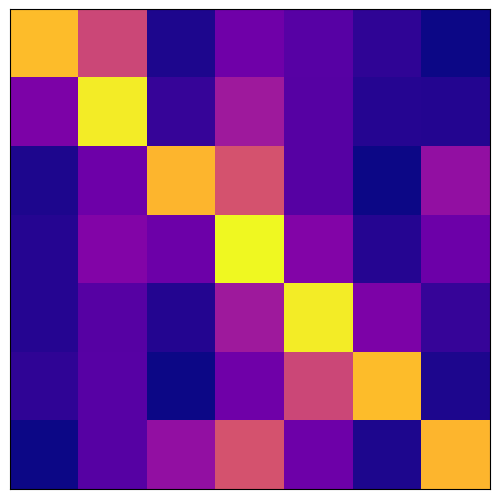

In [ ]:
items_idx = [i-1 for i in items]
SR = computeSR(T,0.85) #Only as an illustration for plotting
SR7 =  SR[np.ix_(items_idx, items_idx)] #Select the subset of 7 objects seen on Day 2
fig,ax = plt.subplots()
img = ax.imshow(SR7, cmap='plasma', aspect='equal')

# Add a colorbar to show the scale
#fig.colorbar(img, label='SR')
ax.set_yticks([])
ax.set_xticks([])

# Remove padding around the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.tight_layout(pad=0)


# Model-based analyses

## Fit gamma to RSAs
The model now uses MSE as loss function. The form of the model is Y* = beta0 + beta1*SR(i,j), where SR is parametrized by $\gamma$.

In [ ]:
#normalize = False
#scale = True
#degree = True

In [ ]:
from scipy.special import expit # Ensure this is imported for gamma calculation

def full_objective(theta,
                   neural_ZNSM,  # CHANGE: Renamed argument for clarity (Z-transformed Neural Similarity Matrix)
                   A,
                   model="SR",
                   normalize=normalizeSR,
                   scaling=True):

    beta1 = theta[1]
    beta2 = np.exp(theta[2])  # CHANGE: Removed the negative sign (-np.exp) to enforce beta2 to be POSITIVE (a)

    if model=="SR":
      gamma = expit(theta[0])
      T = A / A.sum(axis=1, keepdims=True)
      SR = computeSR(T, gamma) #this needs to be T
      # NOTE: The SR is a measure of similarity, and neural_ZNSM is a measure of
      # similarity (Fisher Z-transformed Pearson r). Thus, beta2 should be positive.

      if scaling:
        SR = zscore_matrix(SR)  # Normalize before subsetting

      # Subset the matrix
      x = SR[np.ix_(items_idx, items_idx)]

    elif model=="DK":
      alpha = np.exp(theta[0])
      K = computeDK(A, alpha)
      if scaling:
        K = zscore_matrix(K)  # Normalize before subsetting
      x = K[np.ix_(items_idx, items_idx)]

    elif model=="communicabilityK":
      alpha = np.exp(theta[0])
      T = A / A.sum(axis=1, keepdims=True)
      K = communicabilityK(T, alpha)
      if scaling:
        K = zscore_matrix(K)  # Normalize before subsetting
      x = K[np.ix_(items_idx, items_idx)]

    #x = (x+x.T)/2 # Make the x (either DK or SR) symmetric
    #x = 1-squareform(pdist(x, metric='euclidean')) # Replace euclidean with cosine or correlation
    mask = ~np.eye(len(items_idx), dtype=bool)
    X = beta1 + beta2*x[mask].flatten()
    Y = neural_ZNSM[mask].flatten() # Use Fisher Z-transformed matrix (neural_ZNSM)

    D = (Y-X)**2
    mse = np.mean(D)
    #mse = 1 - pearsonr(x,y)[0]
    return mse

In [ ]:
save_dir = "/content/drive/MyDrive/model_fitting"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
SS_tot = {}
n_pairs = {}

for subj_i, subj in enumerate(neural_ZNSMs):
    SS_tot[subj_i] = {}
    n_pairs[subj_i] = {}
    for h in subj:
        SS_tot[subj_i][h] = {}
        n_pairs[subj_i][h] = {}
        for roi in subj[h]:
            DSM = subj[h][roi]
            mask = ~np.eye(DSM.shape[0], dtype=bool)
            y = DSM[mask].flatten()
            SS_tot[subj_i][h][roi] = np.sum((y - y.mean())**2)
            n_pairs[subj_i][h][roi] = y.size

### DK

In [ ]:
# Model fitting
# This cell fit the DK model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-10, 10), (-100, 100), (-100, 100)] #alpha is from 0 to 100, then beta1 and beta2 are -100, 100

res_DK = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "DK", normalizeSR, True),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]



```
# I get alpha from the list of dictionaries
alphas = [
    {
        h: {
            roi: res[h][roi].x[0]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]
```



In [ ]:
alphas = [
    {
        h: {
            roi: res_DK[p][h][roi].x[0]
            for roi in res_DK[p][h]
        }
        for h in res_DK[p]
    }
    for p in range(len(res_DK))
]

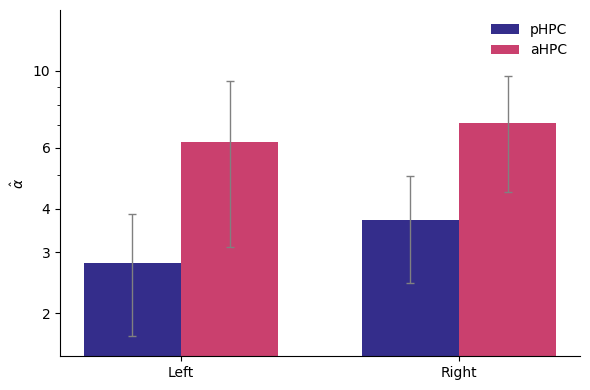

/tmp/ipython-input-2619812692.py:97: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(-0.05 * ymax, ymax + 0.3 * ymax)


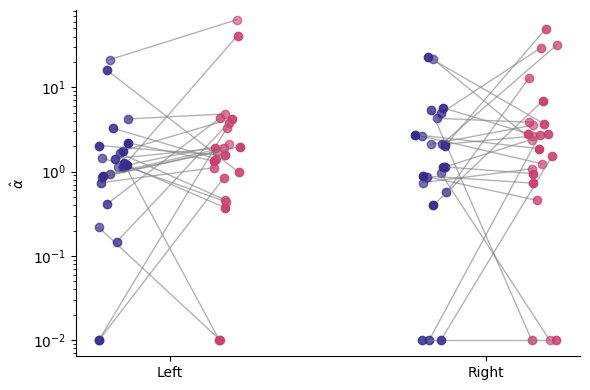

In [ ]:
# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
# data structure: alphas[p][hemi][roi]
# with hemi in {'left', 'right'} and roi in {'posterior', 'anterior'}

nParticipants = len(alphas)
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[np.exp(alphas[p]['left']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['left']['anterior'])  for p in range(nParticipants)]],
    [[np.exp(alphas[p]['right']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['right']['anterior'])  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

# Formatting
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')

# --- Custom tick labels ---
custom_ticks = [2, 3, 4, 6, 10]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(t) for t in custom_ticks])

# --- Axis limits and legend ---
ax.set_ylim(1.5, 15)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (color-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = np.clip(np.exp(alphas[p][h]['posterior']),0.01,100)
        y_ant  = np.clip(np.exp(alphas[p][h]['anterior']),0.01,100)

        # Connect posterior/anterior within participant
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Individual points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

# Formatting
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
# Dynamic y-axis limit with some padding at the bottom and top
ymax = np.max(data)
ax.set_ylim(-0.05 * ymax, ymax + 0.3 * ymax)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Exponential-transformed parameter space (np.exp(-10), np.exp(10))
df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [alphas[p]['left']['posterior'] for p in range(nParticipants)], #We added 1e-12 bc. otherwise it returns NaNs when trying to do log of 0
    [alphas[p]['left']['anterior'] for p in range(nParticipants)]
)
print(f"DK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [alphas[p]['right']['posterior'] for p in range(nParticipants)],
    [alphas[p]['right']['anterior'] for p in range(nParticipants)]
)
print(f"DK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

DK Left hemisphere:  t(22) = -0.702,  p = 0.490
DK Right hemisphere: t(22) = -0.404,  p = 0.690


In [ ]:
# Original parameter space (-10, 10)
df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [np.exp(alphas[p]['left']['posterior']) for p in range(nParticipants)], #We added 1e-12 bc. otherwise it returns NaNs when trying to do log of 0
    [np.exp(alphas[p]['left']['anterior']) for p in range(nParticipants)]
)
print(f"DK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [np.exp(alphas[p]['right']['posterior']) for p in range(nParticipants)],
    [np.exp(alphas[p]['right']['anterior']) for p in range(nParticipants)]
)
print(f"DK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

DK Left hemisphere:  t(22) = -1.329,  p = 0.198
DK Right hemisphere: t(22) = -1.134,  p = 0.269


In [ ]:
R2_DK = []
for subj_i, subj in enumerate(res_DK):  # or 'res' if you didn’t rename
    subj_r2 = {}
    for h in subj:
        subj_r2[h] = {}
        for roi in subj[h]:
            mse = subj[h][roi].fun        # model MSE
            ss = SS_tot[subj_i][h][roi]   # total variance of neural DSM
            n = n_pairs[subj_i][h][roi]   # number of off-diagonal pairs
            r2 = 1 - (n * mse) / ss
            subj_r2[h][roi] = r2
    R2_DK.append(subj_r2)

**Get best-fitting alpha values**

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
hemi_list = ["left", "right"]
roi_list  = ["posterior", "anterior"]

nParticipants = len(alphas)

# ------------------------------------------------------------
# 1. BUILD LONG-FORM DATAFRAME
# ------------------------------------------------------------
rows = []

for p in range(nParticipants):
    for h in hemi_list:
        for r in roi_list:
            log_alpha = alphas[p][h][r]
            true_alpha = np.exp(log_alpha)

            rows.append({
                "participant": p + 1,
                "hemisphere": h,
                "roi": r,
                "log_alpha": log_alpha,
                "alpha": true_alpha,
            })

df = pd.DataFrame(rows)

print("\n================ LONG FORMAT DATAFRAME ================\n")
print(df)


# ------------------------------------------------------------
# 2. OPTIONAL: WIDE FORMAT TABLE (each row = participant)
# ------------------------------------------------------------
df_wide = df.pivot_table(
    index="participant",
    columns=["hemisphere", "roi"],
    values="alpha"
)

print("\n================ WIDE FORMAT DATAFRAME ================\n")
print(df_wide)


# ------------------------------------------------------------
# 3. GROUP STATISTICS
# ------------------------------------------------------------

# hemisphere × ROI means
mean_hemi_roi = df.groupby(["hemisphere", "roi"])["alpha"].mean()

print("\n================ MEAN ALPHA per Hemisphere × ROI ================\n")
print(mean_hemi_roi)


# hemisphere means
mean_hemi = df.groupby("hemisphere")["alpha"].mean()

print("\n================ MEAN ALPHA per Hemisphere ================\n")
print(mean_hemi)


# roi means (across hemispheres)
mean_roi = df.groupby("roi")["alpha"].mean()

print("\n================ MEAN ALPHA per ROI ================\n")
print(mean_roi)


# overall hippocampal mean
overall_mean = df["alpha"].mean()

print("\n================ OVERALL HIPPOCAMPUS MEAN ALPHA ================\n")
print(overall_mean)


# ------------------------------------------------------------
# 4. (Optional) SAVE TABLES TO CSV
# ------------------------------------------------------------
# df.to_csv("alpha_values_long.csv", index=False)
# df_wide.to_csv("alpha_values_wide.csv")



================ LONG FORMAT DATAFRAME ================

    participant hemisphere        roi  log_alpha      alpha
0             1       left  posterior   3.060464  21.337459
1             1       left   anterior   4.151695  63.541607
2             1      right  posterior   3.067883  21.496357
3             1      right   anterior   0.855727   2.353084
4             2       left  posterior   0.123328   1.131255
..          ...        ...        ...        ...        ...
87           22      right   anterior  -0.314680   0.730022
88           23       left  posterior   0.788850   2.200863
89           23       left   anterior   0.287538   1.333141
90           23      right  posterior   1.010699   2.747521
91           23      right   anterior   0.627292   1.872534

[92 rows x 5 columns]

================ WIDE FORMAT DATAFRAME ================

hemisphere        left                 right           
roi           anterior  posterior   anterior  posterior
participant                  

### SR

In [ ]:
# Model fitting
# This cell fit the SR model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-5, 5), (-100, 100), (-100, 100)]

res_SR = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "SR", normalizeSR),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]

In [ ]:
from scipy.special import expit

gammas = [
    {
        h: {
            roi: expit(res_SR[p][h][roi].x[0])   # gamma = sigmoid(theta0)
            for roi in res_SR[p][h]
        }
        for h in res_SR[p]
    }
    for p in range(len(res_SR))
]



```
# I get gamma from the list of dictionaries
gammas = [
    {
        h: {
            roi: expit(res[h][roi].x[0])
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]
```



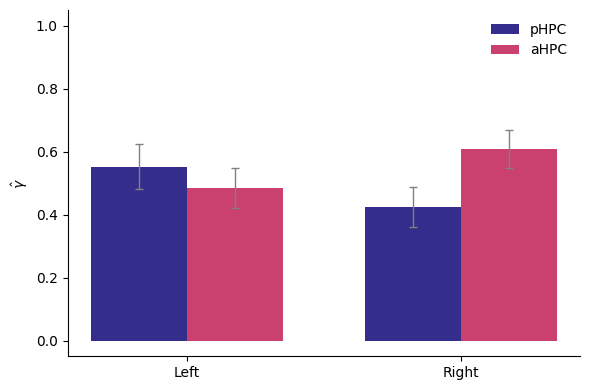

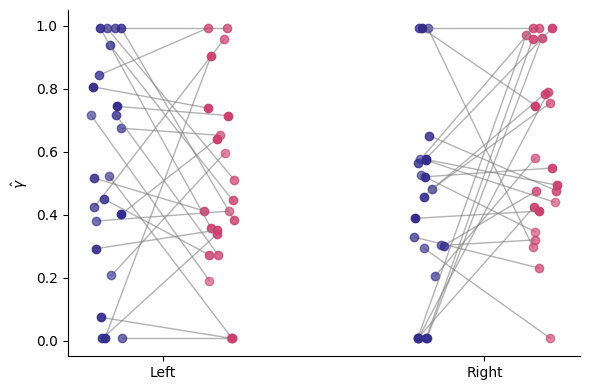

In [ ]:
# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
nParticipants = len(gammas)
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[gammas[p]['left']['posterior'] for p in range(nParticipants)],
     [gammas[p]['left']['anterior']  for p in range(nParticipants)]],
    [[gammas[p]['right']['posterior'] for p in range(nParticipants)],
     [gammas[p]['right']['anterior']  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')
ax.set_ylim(-0.05, 1.05)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (colour-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))  # varying alpha
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05  # slight horizontal jitter

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = gammas[p][h]['posterior']
        y_ant  = gammas[p][h]['anterior']

        # Connect posterior and anterior points
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Plot points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')
ax.set_ylim(-0.05, 1.05)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
R2_SR = []
for subj_i, subj in enumerate(res_SR):  # or 'res' if you didn’t rename
    subj_r2 = {}
    for h in subj:
        subj_r2[h] = {}
        for roi in subj[h]:
            mse = subj[h][roi].fun        # model MSE
            ss = SS_tot[subj_i][h][roi]   # total variance of neural DSM
            n = n_pairs[subj_i][h][roi]   # number of off-diagonal pairs
            r2 = 1 - (n * mse) / ss
            subj_r2[h][roi] = r2
    R2_SR.append(subj_r2)

In [ ]:
# Statistical test
# We use a very simple paired t-test

df = nParticipants - 1

# Left hemisphere
t_stat, p_value = ttest_rel([logit(gammas[p]['left']['posterior']) for p in range(nParticipants)],
                            [logit(gammas[p]['left']['anterior']) for p in range(nParticipants)])

print(f"Left: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

# Right hemisphere
t_stat, p_value = ttest_rel([logit(gammas[p]['right']['posterior']) for p in range(nParticipants)],
                            [logit(gammas[p]['right']['anterior']) for p in range(nParticipants)])

print(f"Right: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

Left: t(22) = 0.726, p = 0.476
Right: t(22) = -1.803, p = 0.085


In [ ]:
# Statistical test
# We use a very simple paired t-test

df = nParticipants - 1

# Left hemisphere
t_stat, p_value = ttest_rel([gammas[p]['left']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['left']['anterior'] for p in range(nParticipants)])

print(f"Left: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

# Right hemisphere
t_stat, p_value = ttest_rel([gammas[p]['right']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['right']['anterior'] for p in range(nParticipants)])

print(f"Right: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

Left: t(22) = 0.824, p = 0.419
Right: t(22) = -2.016, p = 0.056


**Get best-fitting gamma values**

In [ ]:
import numpy as np
import pandas as pd

hemi_list = ["left", "right"]
roi_list  = ["posterior", "anterior"]

nParticipants = len(gammas)

print("\n================ TRUE GAMMA VALUES ================\n")

for p in range(nParticipants):
    print(f"\nParticipant {p+1}:")
    for h in hemi_list:
        for r in roi_list:
            gamma_val = gammas[p][h][r]
            print(f"  {h.capitalize():>6} - {r:<9}: {gamma_val:.4f}")



================ TRUE GAMMA VALUES ================


Participant 1:
    Left - posterior: 0.7170
    Left - anterior : 0.1901
   Right - posterior: 0.5783
   Right - anterior : 0.4389

Participant 2:
    Left - posterior: 0.2067
    Left - anterior : 0.5955
   Right - posterior: 0.5270
   Right - anterior : 0.3450

Participant 3:
    Left - posterior: 0.5233
    Left - anterior : 0.0067
   Right - posterior: 0.2935
   Right - anterior : 0.0067

Participant 4:
    Left - posterior: 0.3795
    Left - anterior : 0.4108
   Right - posterior: 0.9933
   Right - anterior : 0.2962

Participant 5:
    Left - posterior: 0.0067
    Left - anterior : 0.0067
   Right - posterior: 0.2040
   Right - anterior : 0.5784

Participant 6:
    Left - posterior: 0.6746
    Left - anterior : 0.6518
   Right - posterior: 0.3021
   Right - anterior : 0.3196

Participant 7:
    Left - posterior: 0.9933
    Left - anterior : 0.5107
   Right - posterior: 0.3284
   Right - anterior : 0.2302

Participant 8:
    Le

In [ ]:
gamma_array = np.array([
    [
        [gammas[p][h][r] for r in roi_list]
        for h in hemi_list
    ]
    for p in range(nParticipants)
])

In [ ]:
mean_gamma = gamma_array.mean(axis=0)

print("\n================ MEAN GAMMA per Hemisphere × ROI ================\n")
for hi, h in enumerate(hemi_list):
    for ri, r in enumerate(roi_list):
        print(f"{h.capitalize():>6} {r:<9}: {mean_gamma[hi, ri]:.4f}")


================ MEAN GAMMA per Hemisphere × ROI ================

  Left posterior: 0.5521
  Left anterior : 0.4847
 Right posterior: 0.4245
 Right anterior : 0.6081


In [ ]:
print("\n================ MEAN GAMMA per Hemisphere ================\n")
for hi, h in enumerate(hemi_list):
    hemi_mean = gamma_array[:, hi, :].mean()
    print(f"{h.capitalize():>6}: {hemi_mean:.4f}")


================ MEAN GAMMA per Hemisphere ================

  Left: 0.5184
 Right: 0.5163


In [ ]:
overall_gamma = gamma_array.mean()

print("\n================ OVERALL HIPPOCAMPUS MEAN GAMMA ================\n")
print(f"Overall mean gamma: {overall_gamma:.4f}")


================ OVERALL HIPPOCAMPUS MEAN GAMMA ================

Overall mean gamma: 0.5174


### Communicability Kernel

In [ ]:
# Model fitting
# This cell fit the DK model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-10, 10), (-100, 100), (-100, 100)] #alpha is from 0 to 100, then beta1 and beta2 are -100, 100

res_CK = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "communicabilityK", normalizeSR, True),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]

/usr/local/lib/python3.12/dist-packages/scipy/linalg/_matfuncs.py:389: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/tmp/ipython-input-2499640634.py:5: RuntimeWarning: invalid value encountered in subtract
  M_z = (M - vals.mean()) / vals.std(ddof=1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)




```
# Model fitting
# This cell fit the DK model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-7, 5), (-100, 100), (-100, 100)] #alpha is from 0 to 100, then beta1 and beta2 are -100, 100 #0.001, 1

res = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "communicabilityK", normalizeSR, True),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]
```





```
# I get alpha from the list of dictionaries
alphas = [
    {
        h: {
            roi: res[h][roi].x[0]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]
```



In [ ]:
alphas_CK = [
    {
        h: {
            roi: res_CK[p][h][roi].x[0]
            for roi in res_CK[p][h]
        }
        for h in res_CK[p]
    }
    for p in range(len(res_CK))
]

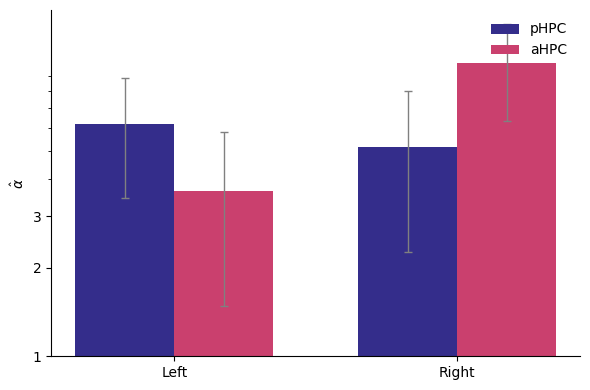

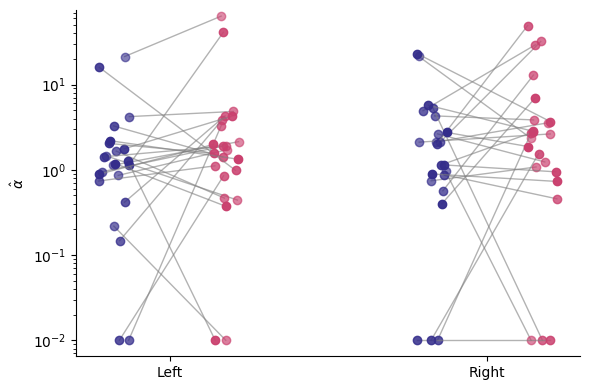

In [ ]:
# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
# data structure: alphas[p][hemi][roi]
# with hemi in {'left', 'right'} and roi in {'posterior', 'anterior'}

nParticipants = len(alphas_CK)
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[np.exp(alphas_CK[p]['left']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas_CK[p]['left']['anterior'])  for p in range(nParticipants)]],
    [[np.exp(alphas_CK[p]['right']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas_CK[p]['right']['anterior'])  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

# Formatting
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')

# --- Custom tick labels ---
custom_ticks = [1, 2, 3]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(t) for t in custom_ticks])

# --- Axis limits and legend ---
#ax.set_ylim(1.5, 20)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (color-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = np.clip(np.exp(alphas[p][h]['posterior']),0.01,100)
        y_ant  = np.clip(np.exp(alphas[p][h]['anterior']),0.01,100)

        # Connect posterior/anterior within participant
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Individual points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

# Formatting
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
# Dynamic y-axis limit with some padding at the bottom and top
ymax = np.max(data)
ax.set_ylim(0.01, 10)
ymin = np.min(data[data > 0])  # avoid zeros
ax.set_ylim(ymin / 0.007, ymax * 1.3)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_rel, t as t_dist

df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [np.exp(alphas_CK[p]['left']['posterior']) for p in range(nParticipants)], #We added 1e-12 bc. otherwise it returns NaNs when trying to do log of 0
    [np.exp(alphas_CK[p]['left']['anterior']) for p in range(nParticipants)]
)
print(f"CK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [np.exp(alphas_CK[p]['right']['posterior']) for p in range(nParticipants)],
    [np.exp(alphas_CK[p]['right']['anterior']) for p in range(nParticipants)]
)
print(f"CK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

CK Left hemisphere:  t(22) = 0.715,  p = 0.482
CK Right hemisphere: t(22) = -1.324,  p = 0.199


In [ ]:
from scipy.stats import ttest_rel, t as t_dist

df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [alphas_CK[p]['left']['posterior'] for p in range(nParticipants)], #We added 1e-12 bc. otherwise it returns NaNs when trying to do log of 0
    [alphas_CK[p]['left']['anterior'] for p in range(nParticipants)]
)
print(f"CK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [alphas_CK[p]['right']['posterior'] for p in range(nParticipants)],
    [alphas_CK[p]['right']['anterior'] for p in range(nParticipants)]
)
print(f"CK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

CK Left hemisphere:  t(22) = 0.080,  p = 0.937
CK Right hemisphere: t(22) = -1.827,  p = 0.081


In [ ]:
R2_CK = []
for subj_i, subj in enumerate(res_CK):  # or 'res' if you didn’t rename
    subj_r2 = {}
    for h in subj:
        subj_r2[h] = {}
        for roi in subj[h]:
            mse = subj[h][roi].fun        # model MSE
            ss = SS_tot[subj_i][h][roi]   # total variance of neural DSM
            n = n_pairs[subj_i][h][roi]   # number of off-diagonal pairs
            r2 = 1 - (n * mse) / ss
            subj_r2[h][roi] = r2
    R2_CK.append(subj_r2)

**Get best-fitting alpha_CK values**

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
hemi_list = ["left", "right"]
roi_list  = ["posterior", "anterior"]

nParticipants = len(alphas_CK)

# ------------------------------------------------------------
# 1. BUILD LONG-FORM DATAFRAME
# ------------------------------------------------------------
rows = []

for p in range(nParticipants):
    for h in hemi_list:
        for r in roi_list:
            log_alpha = alphas_CK[p][h][r]       # stored value = log(alpha)
            true_alpha = np.exp(log_alpha)       # convert to true alpha

            rows.append({
                "participant": p + 1,
                "hemisphere": h,
                "roi": r,
                "log_alpha": log_alpha,
                "alpha": true_alpha,
            })

df_CK = pd.DataFrame(rows)

print("\n================ LONG FORMAT DATAFRAME (CK) ================\n")
print(df_CK)


# ------------------------------------------------------------
# 2. OPTIONAL: WIDE FORMAT TABLE (each row = participant)
# ------------------------------------------------------------
df_CK_wide = df_CK.pivot_table(
    index="participant",
    columns=["hemisphere", "roi"],
    values="alpha"
)

print("\n================ WIDE FORMAT DATAFRAME (CK) ================\n")
print(df_CK_wide)


# ------------------------------------------------------------
# 3. GROUP STATISTICS
# ------------------------------------------------------------

# hemisphere × ROI means
mean_hemi_roi_CK = df_CK.groupby(["hemisphere", "roi"])["alpha"].mean()
print("\n================ MEAN ALPHA (CK) per Hemisphere × ROI ================\n")
print(mean_hemi_roi_CK)

# hemisphere means
mean_hemi_CK = df_CK.groupby("hemisphere")["alpha"].mean()
print("\n================ MEAN ALPHA (CK) per Hemisphere ================\n")
print(mean_hemi_CK)

# ROI means (across hemispheres)
mean_roi_CK = df_CK.groupby("roi")["alpha"].mean()
print("\n================ MEAN ALPHA (CK) per ROI ================\n")
print(mean_roi_CK)

# overall mean across hippocampus
overall_mean_CK = df_CK["alpha"].mean()
print("\n================ OVERALL HIPPOCAMPUS MEAN ALPHA (CK) ================\n")
print(overall_mean_CK)


# ------------------------------------------------------------
# 4. (Optional) SAVE TABLES TO CSV
# ------------------------------------------------------------
# df_CK.to_csv("alpha_values_CK_long.csv", index=False)
# df_CK_wide.to_csv("alpha_values_CK_wide.csv")


================ LONG FORMAT DATAFRAME (CK) ================

    participant hemisphere        roi  log_alpha     alpha
0             1       left  posterior   0.646126  1.908135
1             1       left   anterior  -1.569782  0.208091
2             1      right  posterior   0.637874  1.892454
3             1      right   anterior  -0.535983  0.585094
4             2       left  posterior  -0.625188  0.535161
..          ...        ...        ...        ...       ...
87           22      right   anterior   0.965606  2.626379
88           23       left  posterior  -0.401784  0.669125
89           23       left   anterior   0.888961  2.432602
90           23      right  posterior  -0.070847  0.931604
91           23      right   anterior  -0.403514  0.667968

[92 rows x 5 columns]

================ WIDE FORMAT DATAFRAME (CK) ================

hemisphere        left                 right           
roi           anterior  posterior   anterior  posterior
participant                    

# Model comparison (RH)

In [ ]:
rois = ['posterior', 'anterior']
hemispheres = ['right']
R2_CK = np.asarray([[[r[hem][roi] for roi in rois] for hem in hemispheres] for r in R2_CK])
R2_SR = np.asarray([[[r[hem][roi] for roi in rois] for hem in hemispheres] for r in R2_SR])
R2_DK = np.asarray([[[r[hem][roi] for roi in rois] for hem in hemispheres] for r in R2_DK])

In [ ]:
# Collapse across the ROI dimension
CK = R2_CK[:, 0, :].mean(axis=1)   # shape: (participants,)
SR = R2_SR[:, 0, :].mean(axis=1)
DK = R2_DK[:, 0, :].mean(axis=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

R2s = [SR, CK, DK]
models = ["SR", "CK", "DK"]

means = np.array([r.mean() for r in R2s])
sems  = np.array([r.std(ddof=1) / np.sqrt(len(r)) for r in R2s])

tval = t.ppf(0.975, df=len(CK)-1)
cis = sems * tval

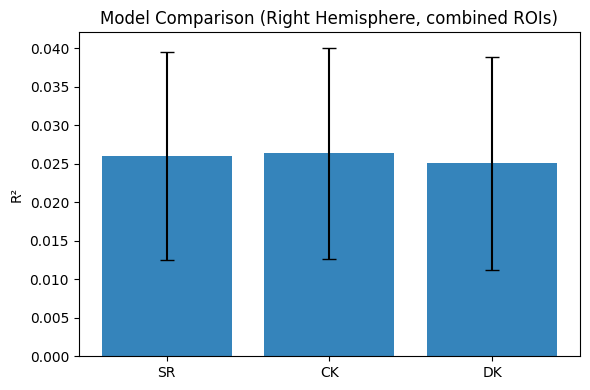

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

x = np.arange(len(models))

ax.bar(
    x, means,
    yerr=cis,
    capsize=5,
    alpha=0.9
)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("R²")
ax.set_title("Model Comparison (Right Hemisphere, combined ROIs)")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_rel

t_SR_CK = ttest_rel(SR, CK)
t_CK_DK = ttest_rel(CK, DK)
t_SR_DK = ttest_rel(SR, DK)

print("SR vs CK:", t_SR_CK)
print("CK vs DK:", t_CK_DK)
print("SR vs DK:", t_SR_DK)

SR vs CK: TtestResult(statistic=np.float64(-0.6805324143988773), pvalue=np.float64(0.5032672871107483), df=np.int64(22))
CK vs DK: TtestResult(statistic=np.float64(0.16796058780260986), pvalue=np.float64(0.868148763093542), df=np.int64(22))
SR vs DK: TtestResult(statistic=np.float64(0.12552278952628831), pvalue=np.float64(0.9012496953461988), df=np.int64(22))


In [ ]:
import numpy as np

def cohens_d_paired(x, y):
    d = x - y
    return d.mean() / d.std(ddof=1)

d_SR_CK = cohens_d_paired(SR, CK)
d_CK_DK = cohens_d_paired(CK, DK)
d_SR_DK = cohens_d_paired(SR, DK)

print("Cohen's d (SR vs CK):", d_SR_CK)
print("Cohen's d (CK vs DK):", d_CK_DK)
print("Cohen's d (SR vs DK):", d_SR_DK)

Cohen's d (SR vs CK): -0.1419008176352283
Cohen's d (CK vs DK): 0.03502220355034306
Cohen's d (SR vs DK): 0.02617331090888353


In [ ]:
print(np.mean(np.mean(R2_CK,(1,2))))
print(np.mean(np.mean(R2_SR,(1,2))))
print(np.mean(np.mean(R2_DK,(1,2))))

0.02632684479493497
0.025984786925187266
0.02502154888038935


In [ ]:
import pandas as pd

In [ ]:
models = ['CK', 'SR', 'DK']

# Stack all R² arrays into one list
R2_all = [R2_CK, R2_SR, R2_DK]

# Build a long-format DataFrame
data = []
for subj_idx in range(R2_DK.shape[0]):
    for m_idx, model in enumerate(models):
        for h_idx, hem in enumerate(hemispheres):
            for r_idx, roi in enumerate(rois):
                data.append({
                    'subject': subj_idx,
                    'model': model,
                    'hemisphere': hem,
                    'roi': roi,
                    'R2': R2_all[m_idx][subj_idx, h_idx, r_idx]
                })

df = pd.DataFrame(data)

In [ ]:
df['model'] = pd.Categorical(df['model'], categories=['DK', 'CK', 'SR'])

In [ ]:
df['model'].cat.categories

Index(['DK', 'CK', 'SR'], dtype='object')

In [ ]:
import statsmodels.formula.api as smf

# Fit linear mixed-effects model with random intercept for subject
model = smf.mixedlm(
    "R2 ~ model + hemisphere + roi",
    data=df,
    groups=df["subject"]
).fit()

print(model.summary())


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  R2      
No. Observations:    138      Method:              REML    
No. Groups:          23       Scale:               0.0013  
Min. group size:     6        Log-Likelihood:      236.8213
Max. group size:     6        Converged:           Yes     
Mean group size:     6.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.036    0.008  4.797 0.000  0.021  0.051
model[T.CK]       0.001    0.007  0.177 0.860 -0.013  0.016
model[T.SR]       0.001    0.007  0.130 0.896 -0.014  0.015
roi[T.posterior] -0.023    0.006 -3.759 0.000 -0.034 -0.011
Group Var         0.000    0.006                           



/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# Fit linear mixed-effects model with random intercept for subject
model = smf.mixedlm(
    "R2 ~ model * (hemisphere + roi)",
    data=df,
    groups=df["subject"]
).fit()

print(model.summary())


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      R2      
No. Observations:        138          Method:                  REML    
No. Groups:              23           Scale:                   0.0013  
Min. group size:         6            Log-Likelihood:          230.2585
Max. group size:         6            Converged:               Yes     
Mean group size:         6.0                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.034    0.009  3.894 0.000  0.017  0.051
model[T.CK]                   0.006    0.011  0.523 0.601 -0.015  0.026
model[T.SR]                   0.004    0.011  0.359 0.719 -0.017  0.024
roi[T.posterior]             -0.018    0.011 -1.710 0.087 -0.039  0.003
model[T.C

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# PXP: Protected Exceedance Probability

In [ ]:
def extract_mse_right(res):
    return np.mean([
        res['right']['posterior'].fun,
        res['right']['anterior'].fun
    ])

In [ ]:
mse_SR_R = np.array([extract_mse_right(res_SR[i]) for i in range(len(res_SR))])
mse_DK_R = np.array([extract_mse_right(res_DK[i]) for i in range(len(res_DK))])
mse_CK_R = np.array([extract_mse_right(res_CK[i]) for i in range(len(res_CK))])

In [ ]:
# import savemat
from scipy.io import savemat

**Akaike Information Criterion (AIC)**

In [ ]:
k = 3      # 4 when including the degree regressor, otherwise 3
nobs = 42  # still 7*7 - 7

AIC_SR_R = 2*k + nobs * np.log(mse_SR_R)
AIC_DK_R = 2*k + nobs * np.log(mse_DK_R)
AIC_CK_R = 2*k + nobs * np.log(mse_CK_R)

In [ ]:
L_right = np.vstack([
    -0.5 * AIC_SR_R,
    -0.5 * AIC_DK_R,
    -0.5 * AIC_CK_R
]).T

In [ ]:
savemat("log_evidence_right.mat", {"L": L_right})

NameError: name 'savemat' is not defined

In [ ]:
# Download savemat
from google.colab import files
#files.download("log_evidence_right.mat")

**Bayesian Information Criterion (BIC)**

In [ ]:
# Number of parameters
k = 3

# Number of data points (off-diagonals in 7x7 matrix)
nobs = 42

# Compute BIC
BIC_SR_R = -2 * np.log(mse_SR_R) + k * np.log(nobs)
BIC_DK_R = -2 * np.log(mse_DK_R) + k * np.log(nobs)
BIC_CK_R = -2 * np.log(mse_CK_R) + k * np.log(nobs)


In [ ]:
L_right = np.vstack([
    - BIC_SR_R,
    - BIC_DK_R,
    - BIC_CK_R
]).T

In [ ]:
savemat("log_evidence_right_BIC.mat", {"L": L_right})

In [ ]:
# Download savemat
from google.colab import files
files.download("log_evidence_right_BIC.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>